In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import nltk
import re
import string
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sb
!pip install wordcloud
from wordcloud import WordCloud

from nltk.stem import WordNetLemmatizer, PorterStemmer, SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer, word_tokenize
from nltk import ngrams
from nltk.util import ngrams
import gensim
from gensim.models.phrases import Phrases
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score

import keras
import tensorflow
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout

!pip install transformers
from transformers import AutoModel, AutoTokenizer, AutoModelForSequenceClassification
from transformers import BertTokenizer, BertModel, BertForSequenceClassification
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Hate Speech Detection

In [ ]:
df_train = pd.read_csv('/content/drive/MyDrive/MSc - CS/nlp/case study/haspeede-master/2020/haspeede2_dev/haspeede2_dev_taskAB.tsv', sep='\t')
df_test_tweets = pd.read_csv("/content/drive/MyDrive/MSc - CS/nlp/case study/haspeede-master/2020/haspeede2_reference/haspeede2_reference_taskAB-tweets.tsv", sep="\t", header=None, names=['id', 'text', 'hs', 'stereotype'])
df_test_news = pd.read_csv("/content/drive/MyDrive/MSc - CS/nlp/case study/haspeede-master/2020/haspeede2_reference/haspeede2_reference_taskAB-news.tsv", sep="\t", header=None, names=['id', 'text', 'hs', 'stereotype'])

## Data Visualization

In [ ]:
df_train.head()

,id,text,hs,stereotype
0,2066,"È terrorismo anche questo, per mettere in uno ...",0,0
1,2045,@user @user infatti finché ci hanno guadagnato...,0,0
2,61,"Corriere: Tangenti, Mafia Capitale dimenticata...",0,0
3,1259,"@user ad uno ad uno, perché quando i migranti ...",0,0
4,949,Il divertimento del giorno? Trovare i patrioti...,0,0


In [ ]:
df_test_tweets.head()

,id,text,hs,stereotype
0,11834,@user A me pare una scelta politica suicida pu...,1,0
1,12113,@user e' un perfetto musulmano!!! chi dice il ...,1,1
2,11770,Mai Tg e i giornaloni hanno parlato di questa ...,1,1
3,11937,@user Ipocriti farabutti. Fanno morire i terre...,1,1
4,11870,@user @user @user L'IMMIGRAZIONE C'E' STATO UN...,1,1


In [ ]:
df_test_news.head()

,id,text,hs,stereotype
0,11976,"Andate pure là, tanto quei fessi degli italian...",1,0
1,12142,Che fine spero che faccia il killer nigeriano ...,1,1
2,12088,Così i profughi ci svuotano i negozi a Pordenone,1,1
3,12030,Così umiliano gli italiani e coccolano i cland...,1,1
4,11775,"Danno soldi ai clandestini, ma ai disabili inv...",1,1


In [ ]:
df_train = df_train.drop(["id"],axis=1)
df_train = df_train.drop(["stereotype"],axis=1)

df_test_tweets = df_test_tweets.drop(["id"],axis=1)
df_test_tweets = df_test_tweets.drop(["stereotype"],axis=1)

df_test_news = df_test_news.drop(["id"],axis=1)
df_test_news = df_test_news.drop(["stereotype"],axis=1)

In [ ]:
df_train.head()

,text,hs
0,"È terrorismo anche questo, per mettere in uno ...",0
1,@user @user infatti finché ci hanno guadagnato...,0
2,"Corriere: Tangenti, Mafia Capitale dimenticata...",0
3,"@user ad uno ad uno, perché quando i migranti ...",0
4,Il divertimento del giorno? Trovare i patrioti...,0


In [ ]:
df_test_tweets.head()

,text,hs
0,@user A me pare una scelta politica suicida pu...,1
1,@user e' un perfetto musulmano!!! chi dice il ...,1
2,Mai Tg e i giornaloni hanno parlato di questa ...,1
3,@user Ipocriti farabutti. Fanno morire i terre...,1
4,@user @user @user L'IMMIGRAZIONE C'E' STATO UN...,1


In [ ]:
df_test_news.head()

,text,hs
0,"Andate pure là, tanto quei fessi degli italian...",1
1,Che fine spero che faccia il killer nigeriano ...,1
2,Così i profughi ci svuotano i negozi a Pordenone,1
3,Così umiliano gli italiani e coccolano i cland...,1
4,"Danno soldi ai clandestini, ma ai disabili inv...",1


In [ ]:
df_train['hs'].value_counts()

0    4071
1    2766
Name: hs, dtype: int64

In [ ]:
df_test_tweets['hs'].value_counts()

0    641
1    622
Name: hs, dtype: int64

In [ ]:
df_test_news['hs'].value_counts()

0    319
1    181
Name: hs, dtype: int64

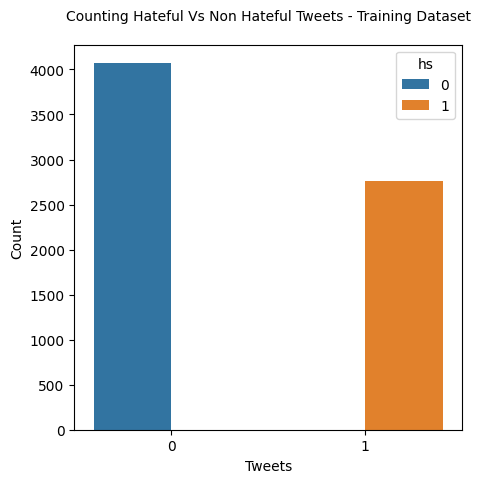

In [ ]:
import seaborn as sns

plt.figure(figsize=(5,5))
sns.countplot(data=df_train, x='hs', hue='hs')
plt.title("Counting Hateful Vs Non Hateful Tweets - Training Dataset\n", fontsize=10)
plt.xlabel('Tweets')
plt.ylabel("Count")
plt.show()

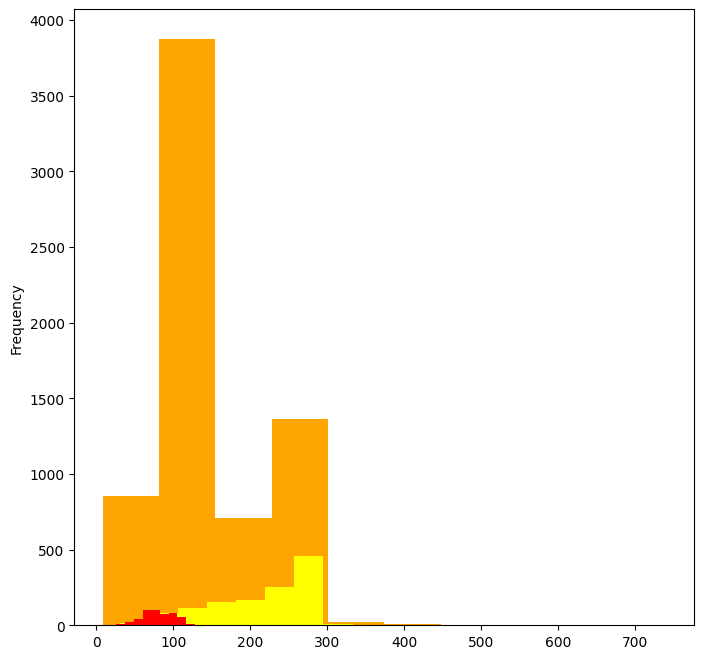

In [ ]:
train_data_len = df_train['text '].str.len().plot.hist(color = 'orange' , figsize = (8,8))
test_data_len = df_test_tweets['text'].str.len().plot.hist(color = 'yellow' , figsize = (8,8))
test_data_len = df_test_news['text'].str.len().plot.hist(color = 'red' , figsize = (8,8))

In [ ]:
for i in range(len(df_train)):
  print(df_train['text '][i])

Output streaming troncato alle ultime 5000 righe.
@user @user dei compagni lo dicevano già 2/3 anni fa ora che lo dice il profeta va bene 
Roma, maxi rissa nel campo rom durante il censimento del Comune (CiociariaReport24) URL URL 
Lulic zingaro , rom di merda. Anche questa è verità �� URL 
@user non la farei drammatica. Era uno scherzo idiota. La rom sta bene ci sono pure le foto. L'altra continua a rovistare tranquilla 
@user Ma soprattutto quando a non apprezzare la satira su di sé erano gli islamici. Lì eravamo tutti un profluvio di ironia. 
@user Flavia Perina:"Ilham e le altre...italiani nella vita, stranieri per la burocrazia e per la politica pavida"(io citt. mondo) 
Trump licenzia il ministro della Giustizia: non voleva difendere il bando anti-islamici (Il Messaggero)… URL 
#EroStraniero? Ma anche no... ancora una volta paragonare l'immigrazione italiana nei primi '900 con quella incontrollata di adesso è pazzia 
Quanti sono gli stranieri che vivono in Italia URL 
aggiornament

In [ ]:
for i in range(len(df_test_tweets)):
  print(df_test_tweets['text'][i])

@user A me pare una scelta politica suicida puntare tutto su una battaglia sicuramente perdente in favore dell'immigrazione incontrollata...Meglio così, spariranno più velocemente!
@user e' un perfetto musulmano!!! chi dice il contrario mente, applica alla lettera la sura "la donna" del Corano. Il pericolo non e' lui in quanto tale, che lo dice, ma gli infami bugiardi! dell' islam moderato che NON ESISTE,
Mai Tg e i giornaloni hanno parlato di questa ennesima porcata fatta da immigrati ?? ⤵️⤵️⤵️⤵️  Sanremo, Segregata e stuprata per mesi. La giovane sequestrata da sei immigrati. Legata al letto e stuprata a turno per due mesi. Poi ceduta ad altri "clienti"  URL
@user Ipocriti farabutti. Fanno morire i terremotati per I Bastardi clandestini immigrati schifosi.
@user @user @user L'IMMIGRAZIONE C'E' STATO UN CALO FISIOLOGICO QUANTI RINPATRII HA FATTO ? CI SONO MIGLIAIA DI IMMIGRATI IRREGOLARI CHE DELINQUONO TUTTI I GIORNI SUL TERRITORIO ITALIANI NON POSSONO ESSERE PUNITI DALLA GIUSTIZIA  I

In [ ]:
for i in range(len(df_test_news)):
  print(df_test_news['text'][i])

Andate pure là, tanto quei fessi degli italiani.... Capito perché ci invadono? Il clandestino confessa
Che fine spero che faccia il killer nigeriano di Pamela. La furia cieca della Meloni: le sue parole più dure
Così i profughi ci svuotano i negozi a Pordenone
Così umiliano gli italiani e coccolano i clandestini. La follia del governo: "Per loro gratis...", e ci invadono
Danno soldi ai clandestini, ma ai disabili invece.... Bracconeri, il figlio autistico e il durissimo sfogo a "Libero"
Emergenza, Minniti annulla il viaggio e torna in Italia. Immigrati, invasione alle porte: cose mai viste prima
Gli immigrati sono matti, parola di scienziati. Malattie mentali e "risorse", lo studio horror
Ho chiesto ai profughi di lavorare ma preferiscono non fare nulla
Immigrati bomba sociale Subito via 600mila irregolari
Immigrati, così la sinistra ci costringe a tenerli tutti. Meloni, la denuncia: "Il trucco giuridico per rovinare l'Italia"
Immigrati, venite tutti qui. L'ultima "perla" del Papa: con

## Data Pre-Processing

In [ ]:
def cleaning_text(text):
  text = text.lower()
  text = re.sub(r'@user', '', text)
  text = re.sub(r' @[a-z0-9]+ ', '', text)
  text = re.sub(r' \b(\w+?)(\w)\2+\b ', r'\1\2', text)
  text = re.sub(r' VIDEO ', '', text)
  text = re.sub(r'&gt;', '', text)
  text = re.sub(r' \b\w+\.\w+\b ', '', text)
  text = text.replace('retweet', '')
  text = text.replace('url', '')
  text = text.replace('#', '')
  text = text.replace('€' , " euro ")
  text = text.replace(' + ', '')
  text = re.sub(r" x ", "per", text)
  text = re.sub(r" nn ", "non", text)
  text = re.sub(r" xk ", "perchè", text)
  text = re.sub(r" xké ", "perchè", text)
  text = re.sub(r"[^a-z\s\(\-:\)\\\/\];='#]", ' ', text)
  text = re.sub("[^a-z0-9<>]", ' ', text)
  text = re.sub(r' toh ', '', text)

  stop_words = set(stopwords.words('italian'))
  text = [word for word in text.split() if (word not in stop_words and word not in string.punctuation)]

  return ' '.join(text)

def preprocessing(text):
  text = text.split()

  stemmer = SnowballStemmer("italian")
  text = [stemmer.stem(word) for word in text]

  return ' '.join(text)

# Preprocess the training tweets
X_clean_train = df_train['text '].apply(cleaning_text)
df_train['clean_text'] = X_clean_train.apply(preprocessing)
X_train = df_train['clean_text']
y_train = df_train['hs']

# Preprocess the testing tweets
X_clean_test = df_test_tweets['text'].apply(cleaning_text)
df_test_tweets['clean_text'] = X_clean_test.apply(preprocessing)

# Preprocess the testing news
X_clean_test = df_test_news['text'].apply(cleaning_text)
df_test_news['clean_text'] = X_clean_test.apply(preprocessing)

In [ ]:
for i in range(len(df_train)):
  print(df_train['clean_text'][i])

Output streaming troncato alle ultime 5000 righe.
udin invas sindac fa domand aver ancor pi profug
moden sindac pd regal benzin famigl rom port bambin scuol notiziar onlin
compagn dic gi anni fa ora dic profet va ben
rom max riss camp rom durant cens comun ciociariareport
lulic zingar rom merd verit
drammat scherz idiot rom ben pur fot altra continu rovist tranquill
soprattutt quand apprezz satir s islam profluv iron
flav perin ilham altre italian vit stranier burocraz polit pavid citt mond
trump licenz ministr giustiz vol difend band anti islam messagger
erostranier no ancor volt paragon immigr italian prim incontroll adess pazz
stranier viv ital
aggiorn asi indones croc fatt artig musulm simbol giorn indonesian
centinai migliai stranier gir sap impun ital ringraz istitu
ital chiam nomad ricerc quind spost citt altra
rom ferrar migrant impost reazion soluzion divers
scus ragg quand rom pag qualsias tass demagog via
dallavostrapart rom rapin cines mort sott tren domiciliar camp rom
due

In [ ]:
for i in range(len(df_test_tweets)):
  print(df_test_tweets['clean_text'][i])

me par scelt polit suicid punt battagl sicur perdent favor immigr incontroll megl cos spar pi veloc
perfett musulm dic contrar ment applic letter sur donn cor pericol tal dic infam bugiard islam moder esist
mai tg giornalon parl ennesim porc fatt immigr sanrem segreg stupr mes giovan sequestr immigr leg lett stupr turn due mes poi ced altri client
ipocr farabutt mor terremot bastard clandestin immigr schifos
immigr stat cal fisiolog quantirinpatrih fatt migliai immigr irregolar delinqu giorn territor italian poss esser pun giustiz profug quind
cert tuttiquell gir vuot senz far uncazz ce dobb ten espatrioooooo gal pien stranier dobb manten bastaaaaa
ragion cor prescriv lott infedel sottomission nessun convivt pacif men mai paritet
riguard accogl indiscriminat port sol parass stuprator spacciator maf nigerian tant traffic organ uman molt men sicurezz migrant fic accoglit signif cresc sicurezz
dom merd vogl accett altre merd mussulman vien ment cos prepar oppur sol merd chenonpens no sold

In [ ]:
for i in range(len(df_test_news)):
  print(df_test_news['clean_text'][i])

andat pur tant que fess italian cap perc invad clandestin confess
fin sper killer niger pamel fur ciec melon parol pi dur
cos profug svuot negoz pordenon
cos umil italian coccol clandestin foll govern gratis invad
dann sold clandestin disabil invec bracconer figl autist durissim sfog liber
emergt minn annull viagg torn ital immigr invasion port cos mai vist prim
immigr matt parol scienz malatt mental risors stud horror
chiest profug lavor prefer far null
immigr bomb social sub via mil irregolar
immigr cos sinistr costring ten melon denunc trucc giurid rovin ital
immigr ven qui ultim perl pap scalfar tif invasion
invas immigr rest sol possibilit drastic ide general jean salv ital
govern ridurr clandestin stuprator giorg melon lezion sinistr ridott schif
ostagg immigr ecco ridott
ital serv calpest invas adess bast immigr feltr sal panzer atto forz
immigr indiscrimin port islamizz
macc pover disper fals profug
malar sol iniz trem profez leghist afric cos succeder ital
migrant profug comun

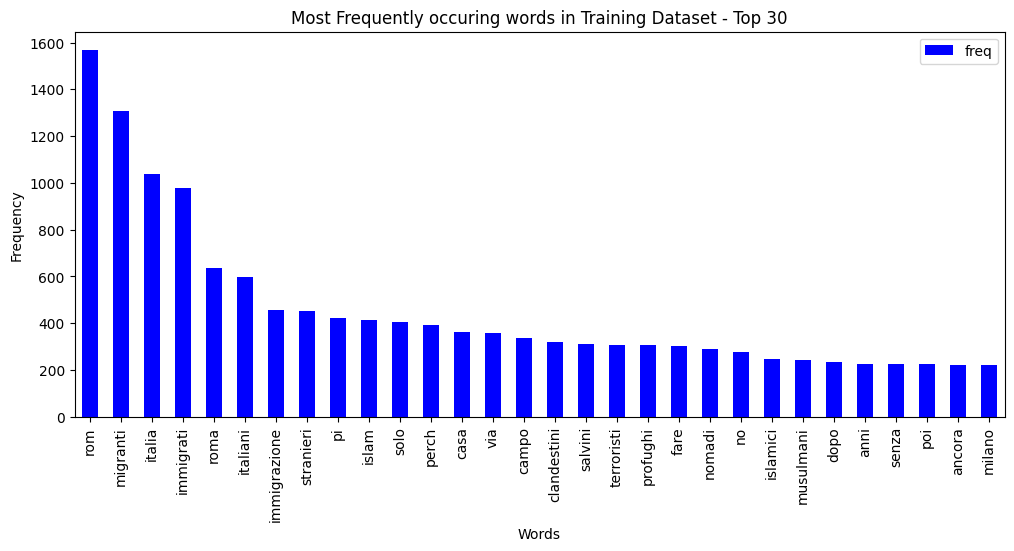

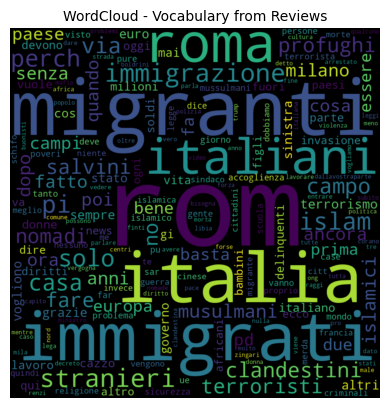

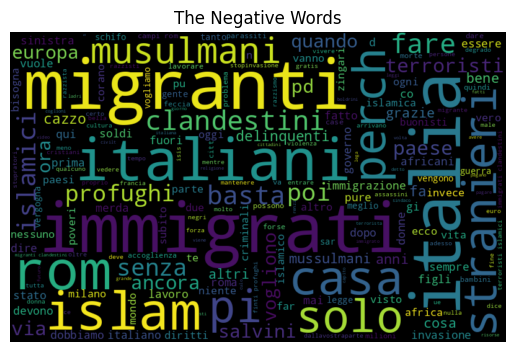

In [ ]:
# Most frequently occurred words
italian_stop_words = nltk.corpus.stopwords.words('italian')
cv = CountVectorizer(stop_words=italian_stop_words)
word = cv.fit_transform(X_clean_train)

sum_words = word.sum(axis=0)

words_freq = [(word, sum_words[0,i]) for word, i in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key=lambda x:x[1], reverse=True)
frequency = pd.DataFrame(words_freq, columns=["word", "freq"])
frequency.head(30).plot(x='word', y='freq', kind='bar', figsize=(12,5), color= "blue")
plt.title("Most Frequently occuring words in Training Dataset - Top 30")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.show()

# WordCloud for overall vocabulary from reviews
plt.title("WordCloud - Vocabulary from Reviews", fontsize=10)
wc = WordCloud(background_color='black', width=1000, height=1000).generate_from_frequencies(dict(words_freq))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

# WordCloud for negative words
plt.title('The Negative Words')
negative_words = ' '.join([text for text, label in zip(X_clean_train, df_train['hs']) if label == 1])
nw = WordCloud(background_color='black', width=800, height=500, random_state=0, max_font_size=110).generate(negative_words)
plt.imshow(nw, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
df_train

,text,hs,clean_text
0,"È terrorismo anche questo, per mettere in uno ...",0,terror mett stat soggezion person rend innocu ...
1,@user @user infatti finché ci hanno guadagnato...,0,infatt finc guadagn camp rom ok alemann ipocr
2,"Corriere: Tangenti, Mafia Capitale dimenticata...",0,corr tangent maf capital dimenticatamazzett bu...
3,"@user ad uno ad uno, perché quando i migranti ...",0,perc quand migrant israel arriv terr canaan fu...
4,Il divertimento del giorno? Trovare i patrioti...,0,divert giorn trov patriot italian innegg rom s...
...,...,...,...
6832,Gli stati nazionali devono essere pronti a rin...,0,stat nazional dev esser pront rinunc propr sov...
6833,Il ministro dell'interno della Germania #Horst...,0,ministr intern german horstseehofer propost da...
6834,#Salvini: In Italia troppi si sono montati la ...,0,salvin ital tropp mont test ringraz dio mes st...
6835,@user @user Chi giubila in buona fede non ha c...,0,giubil buon fed cap nient purtropp cred pi buo...


In [ ]:
df_test_tweets

,text,hs,clean_text
0,@user A me pare una scelta politica suicida pu...,1,me par scelt polit suicid punt battagl sicur p...
1,@user e' un perfetto musulmano!!! chi dice il ...,1,perfett musulm dic contrar ment applic letter ...
2,Mai Tg e i giornaloni hanno parlato di questa ...,1,mai tg giornalon parl ennesim porc fatt immigr...
3,@user Ipocriti farabutti. Fanno morire i terre...,1,ipocr farabutt mor terremot bastard clandestin...
4,@user @user @user L'IMMIGRAZIONE C'E' STATO UN...,1,immigr stat cal fisiolog quantirinpatrih fatt ...
...,...,...,...
1258,Il Razzismo gli viene inculcato sin da bambini...,1,razzism vien inculc sin bambin cor islam can m...
1259,PERCHÉ DI QUESTO ORRENDO STUPRO NON DI PARLA? ...,1,perc orrend stupr parl inform corrott sinistr ...
1260,FERMIAMO L'IMPOSTORE. Forse saranno necesarie ...,1,ferm impostor fors necesar altre croc vist fiu...
1261,@user @user @user @user @user @user @user @use...,1,matte tocc fuor delinquent stranier cas


In [ ]:
df_test_news

,text,hs,clean_text
0,"Andate pure là, tanto quei fessi degli italian...",1,andat pur tant que fess italian cap perc invad...
1,Che fine spero che faccia il killer nigeriano ...,1,fin sper killer niger pamel fur ciec melon par...
2,Così i profughi ci svuotano i negozi a Pordenone,1,cos profug svuot negoz pordenon
3,Così umiliano gli italiani e coccolano i cland...,1,cos umil italian coccol clandestin foll govern...
4,"Danno soldi ai clandestini, ma ai disabili inv...",1,dann sold clandestin disabil invec bracconer f...
...,...,...,...
495,"Sea Watch, il pm fa sbarcare i migranti. Salvi...",0,sea watc pm fa sbarc migrant salvin denunc ape...
496,Il pm fa sbarcare i migranti Il capo leghista ...,0,pm fa sbarc migrant cap leghist sment tv
497,"Pisa, il poster di Salvini con i migranti fatt...",0,pis poster salvin migrant fatt student ceccard...
498,Sea Watch e lo sbarco del migrante con una sol...,0,sea watc sbarc migrant sol gamb poss realizz sogn



# Feature-extraction approaches and Text Classification
Test Dataset: Tweets

In [ ]:
X_test = df_test_tweets['clean_text']
y_test = df_test_tweets['hs']

## W2V

In [ ]:
# Word2Vector embeddings
def get_embeddings(tokenized_data):
  X_data = []
  for tokens in tokenized_data:
      embeddings = []
      for word in tokens:
          if word in model_w2v.wv:
              embeddings.append(model_w2v.wv[word])
      if embeddings:
          X_data.append(np.mean(embeddings, axis=0))
      else:
          X_data.append(np.zeros(model_w2v.vector_size)) # case where all tokens are out-of-vocabulary
  return X_data

# Word2Vec training dataset
w2v_train_data = list(map(lambda x: x.split(), df_train['clean_text']))

# Word2Vector model
model_w2v = gensim.models.Word2Vec(
            w2v_train_data,
            vector_size=200, # desired number of features/independent variables
            window=5, # context window size
            min_count=5,
            sg = 1, # 1 for skip-gram model
            hs = 0,
            negative = 10, # for negative sampling
            workers= 100, # number of cores
            seed = 42)

model_w2v.train(w2v_train_data, total_examples = len(w2v_train_data), epochs=20)

(1353753, 1781640)

### SVM, Random Forest, GradientBoosting Classifier

In [ ]:
# Tokenize cleaned tweets
tt = TweetTokenizer()
tokenized_train = df_train['clean_text'].apply(lambda x: tt.tokenize(x))
tokenized_test = df_test_tweets['clean_text'].apply(lambda x: tt.tokenize(x))

X_train = get_embeddings(tokenized_train)
X_train = np.array(X_train)
y_train = df_train['hs']

X_test = get_embeddings(tokenized_test)
y_test = df_test_tweets['hs']

# ML models (SVM, Random Forest, Gradient Boosting)
svm = SVC()
rf = RandomForestClassifier()
gb = GradientBoostingClassifier()

models = [svm, rf, gb]
model_names = ['SVM', 'Random Forest', 'Gradient Boosting']
accuracy_scores = []
f1_scores = []

# TRAINING
kf = KFold(n_splits=5, shuffle=True, random_state=42)
for model in models:
    model_accuracy_scores = []
    model_f1_scores = []

    for train_index, val_index in kf.split(X_train):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        # Fit the model on the training fold
        model.fit(X_train_fold, y_train_fold)

        # Predict on the validation fold
        y_pred = model.predict(X_val_fold)

        # Compute accuracy and F1 score for the fold
        accuracy = accuracy_score(y_val_fold, y_pred)
        f1 = f1_score(y_val_fold, y_pred, average='macro')

        model_accuracy_scores.append(accuracy)
        model_f1_scores.append(f1)

    # Compute average accuracy and F1 score across all folds for the model
    avg_accuracy = np.mean(model_accuracy_scores)
    avg_f1 = np.mean(model_f1_scores)

    accuracy_scores.append(avg_accuracy)
    f1_scores.append(avg_f1)

print('TRAINING AND VALIDATION')
results_df = pd.DataFrame({'Model': model_names, 'Accuracy': accuracy_scores, 'F1-Score': f1_scores})
print(results_df)


# TESTING
test_accuracy_scores = []
test_f1_scores = []

for model in models:
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')

    test_accuracy_scores.append(accuracy)
    test_f1_scores.append(f1)

print('\nTESTING')
test_results_df = pd.DataFrame({'Model': model_names, 'Accuracy': test_accuracy_scores, 'F1-Score': test_f1_scores})
print(test_results_df)

TRAINING AND VALIDATION
               Model  Accuracy  F1-Score
0                SVM  0.753543  0.743107
1      Random Forest  0.729703  0.710284
2  Gradient Boosting  0.733653  0.720119

TESTING
               Model  Accuracy  F1-Score
0                SVM  0.732383  0.731222
1      Random Forest  0.701504  0.701073
2  Gradient Boosting  0.699921  0.697368


### BidirectionalLSTM

Bilinear LSTM - lr = 0.001


In [ ]:
vocab = model_w2v.wv.key_to_index # vocabulary learned by the w2v model

vocab = list(vocab.keys())
word_vec_dict = {}
for word in vocab:
  word_vec_dict[word] = model_w2v.wv.get_vector(word)

maxi = -1
for i,rev in enumerate(df_train['clean_text']):
    tokens = rev.split()
    if(len(tokens) > maxi):
        maxi = len(tokens)

# Tokenize the clean tweets
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train['clean_text'])
vocab_size = len(tokenizer.word_index) + 1
encd_rev = tokenizer.texts_to_sequences(df_train['clean_text'])

max_rev_len = len(word_vec_dict)  # max lenght of a review
vocab_size = len(tokenizer.word_index) + 1  # total no of words
embed_dim = 200 # embedding dimension as choosen in word2vec constructor

pad_rev= pad_sequences(encd_rev, maxlen=max_rev_len, padding='post')

# Embedding matrix
embed_matrix = np.zeros(shape=(vocab_size, embed_dim))
for word,i in tokenizer.word_index.items():
  embed_vector = word_vec_dict.get(word)
  if embed_vector is not None:  # word is in the vocabulary learned by the w2v model
    embed_matrix[i] = embed_vector
  # if word is not found then embed_vector corressponding to that vector will stay zero

# TRAINING
epochs = 10
batch_size = 32

Y = keras.utils.to_categorical(df_train['hs'])  # one hot target as required by NN.
x_train, x_val, y_train, y_val = train_test_split(pad_rev, Y ,test_size=0.20,random_state=42)

# Define the LSTM model
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length=max_rev_len, weights=[embed_matrix], trainable=False))
model.add(Bidirectional(LSTM(128)))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2, activation='sigmoid'))

optimizer = Adam
learning_rate = 0.001

model.compile(optimizer=Adam(lr=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_val, y_val))

# TESTING
X_test = pad_sequences(tokenizer.texts_to_sequences(df_test_tweets['clean_text']), maxlen=max_rev_len, padding='post')
y_test = keras.utils.to_categorical(df_test_tweets['hs'])

y_pred_test = model.predict(X_test)
y_pred_labels_test = np.argmax(y_pred_test, axis=1)

test_accuracy = accuracy_score(np.argmax(y_test, axis=1), y_pred_labels_test)
test_f1_macro = f1_score(np.argmax(y_test, axis=1), y_pred_labels_test, average='macro')

results_test = {'Test Accuracy': test_accuracy, 'Test F1 Macro Score': test_f1_macro}
results_df_test = pd.DataFrame(results_test, index=[0])

print("TESTING")
print(results_df_test)

Epoch 1/10
171/171 [==============================] - 50s 244ms/step - loss: 0.5903 - accuracy: 0.6892 - val_loss: 0.5354 - val_accuracy: 0.7222
Epoch 2/10
171/171 [==============================] - 32s 184ms/step - loss: 0.5161 - accuracy: 0.7455 - val_loss: 0.5367 - val_accuracy: 0.7303
Epoch 3/10
171/171 [==============================] - 30s 174ms/step - loss: 0.5039 - accuracy: 0.7515 - val_loss: 0.5113 - val_accuracy: 0.7442
Epoch 4/10
171/171 [==============================] - 29s 168ms/step - loss: 0.4868 - accuracy: 0.7654 - val_loss: 0.5008 - val_accuracy: 0.7442
Epoch 5/10
171/171 [==============================] - 31s 182ms/step - loss: 0.4633 - accuracy: 0.7745 - val_loss: 0.5155 - val_accuracy: 0.7390
Epoch 6/10
171/171 [==============================] - 49s 285ms/step - loss: 0.5347 - accuracy: 0.7202 - val_loss: 0.5173 - val_accuracy: 0.7434
Epoch 7/10
171/171 [==============================] - 54s 317ms/step - loss: 0.4882 - accuracy: 0.7632 - val_loss: 0.5112 - val_ac

Bilinear LSTM - lr = 0.0001


In [ ]:
vocab = model_w2v.wv.key_to_index # vocabulary learned by the w2v model

vocab = list(vocab.keys())
word_vec_dict = {}
for word in vocab:
  word_vec_dict[word] = model_w2v.wv.get_vector(word)

maxi = -1
for i,rev in enumerate(df_train['clean_text']):
    tokens = rev.split()
    if(len(tokens) > maxi):
        maxi = len(tokens)

# Tokenize the clean tweets
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train['clean_text'])
vocab_size = len(tokenizer.word_index) + 1
encd_rev = tokenizer.texts_to_sequences(df_train['clean_text'])

max_rev_len = len(word_vec_dict)  # max lenght of a review
vocab_size = len(tokenizer.word_index) + 1  # total no of words
embed_dim = 200 # embedding dimension as choosen in word2vec constructor

pad_rev= pad_sequences(encd_rev, maxlen=max_rev_len, padding='post')

# Embedding matrix
embed_matrix = np.zeros(shape=(vocab_size, embed_dim))
for word,i in tokenizer.word_index.items():
  embed_vector = word_vec_dict.get(word)
  if embed_vector is not None:  # word is in the vocabulary learned by the w2v model
    embed_matrix[i] = embed_vector
  # if word is not found then embed_vector corressponding to that vector will stay zero

# TRAINING
epochs = 10
batch_size = 32

Y = keras.utils.to_categorical(df_train['hs'])  # one hot target as required by NN.
x_train, x_val, y_train, y_val = train_test_split(pad_rev, Y ,test_size=0.20,random_state=42)

# Define the LSTM model
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length=max_rev_len, weights=[embed_matrix], trainable=False))
model.add(Bidirectional(LSTM(128)))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2, activation='sigmoid'))

optimizer = Adam
learning_rate = 0.0001

model.compile(optimizer=Adam(lr=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_val, y_val))

# TESTING
X_test = pad_sequences(tokenizer.texts_to_sequences(df_test_tweets['clean_text']), maxlen=max_rev_len, padding='post')
y_test = keras.utils.to_categorical(df_test_tweets['hs'])

y_pred_test = model.predict(X_test)
y_pred_labels_test = np.argmax(y_pred_test, axis=1)

test_accuracy = accuracy_score(np.argmax(y_test, axis=1), y_pred_labels_test)
test_f1_macro = f1_score(np.argmax(y_test, axis=1), y_pred_labels_test, average='macro')

results_test = {'Test Accuracy': test_accuracy, 'Test F1 Macro Score': test_f1_macro}
results_df_test = pd.DataFrame(results_test, index=[0])

print("TESTING")
print(results_df_test)

Epoch 1/10
171/171 [==============================] - 55s 245ms/step - loss: 0.5894 - accuracy: 0.6701 - val_loss: 0.5410 - val_accuracy: 0.7237
Epoch 2/10
171/171 [==============================] - 29s 169ms/step - loss: 0.5322 - accuracy: 0.7351 - val_loss: 0.5262 - val_accuracy: 0.7376
Epoch 3/10
171/171 [==============================] - 28s 164ms/step - loss: 0.5040 - accuracy: 0.7594 - val_loss: 0.5164 - val_accuracy: 0.7500
Epoch 4/10
171/171 [==============================] - 31s 181ms/step - loss: 0.4808 - accuracy: 0.7713 - val_loss: 0.5456 - val_accuracy: 0.7325
Epoch 5/10
171/171 [==============================] - 32s 187ms/step - loss: 0.4658 - accuracy: 0.7714 - val_loss: 0.5056 - val_accuracy: 0.7449
Epoch 6/10
171/171 [==============================] - 33s 192ms/step - loss: 0.4533 - accuracy: 0.7791 - val_loss: 0.5088 - val_accuracy: 0.7266
Epoch 7/10
171/171 [==============================] - 29s 168ms/step - loss: 0.4311 - accuracy: 0.7841 - val_loss: 0.5356 - val_ac

Bilinear LSTM - lr = 0.00001


In [ ]:
vocab = model_w2v.wv.key_to_index # vocabulary learned by the w2v model

vocab = list(vocab.keys())
word_vec_dict = {}
for word in vocab:
  word_vec_dict[word] = model_w2v.wv.get_vector(word)

maxi = -1
for i,rev in enumerate(df_train['clean_text']):
    tokens = rev.split()
    if(len(tokens) > maxi):
        maxi = len(tokens)

# Tokenize the clean tweets
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train['clean_text'])
vocab_size = len(tokenizer.word_index) + 1
encd_rev = tokenizer.texts_to_sequences(df_train['clean_text'])

max_rev_len = len(word_vec_dict)  # max lenght of a review
vocab_size = len(tokenizer.word_index) + 1  # total no of words
embed_dim = 200 # embedding dimension as choosen in word2vec constructor

pad_rev= pad_sequences(encd_rev, maxlen=max_rev_len, padding='post')

# Embedding matrix
embed_matrix = np.zeros(shape=(vocab_size, embed_dim))
for word,i in tokenizer.word_index.items():
  embed_vector = word_vec_dict.get(word)
  if embed_vector is not None:  # word is in the vocabulary learned by the w2v model
    embed_matrix[i] = embed_vector
  # if word is not found then embed_vector corressponding to that vector will stay zero

# TRAINING
epochs = 10
batch_size = 32

Y = keras.utils.to_categorical(df_train['hs'])  # one hot target as required by NN.
x_train, x_val, y_train, y_val = train_test_split(pad_rev, Y ,test_size=0.20,random_state=42)

# Define the LSTM model
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length=max_rev_len, weights=[embed_matrix], trainable=False))
model.add(Bidirectional(LSTM(128)))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2, activation='sigmoid'))

optimizer = Adam
learning_rate = 0.00001

model.compile(optimizer=Adam(lr=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_val, y_val))

# TESTING
X_test = pad_sequences(tokenizer.texts_to_sequences(df_test_tweets['clean_text']), maxlen=max_rev_len, padding='post')
y_test = keras.utils.to_categorical(df_test_tweets['hs'])

y_pred_test = model.predict(X_test)
y_pred_labels_test = np.argmax(y_pred_test, axis=1)

test_accuracy = accuracy_score(np.argmax(y_test, axis=1), y_pred_labels_test)
test_f1_macro = f1_score(np.argmax(y_test, axis=1), y_pred_labels_test, average='macro')

results_test = {'Test Accuracy': test_accuracy, 'Test F1 Macro Score': test_f1_macro}
results_df_test = pd.DataFrame(results_test, index=[0])

print("TESTING")
print(results_df_test)

Epoch 1/10
171/171 [==============================] - 54s 262ms/step - loss: 0.5881 - accuracy: 0.6890 - val_loss: 0.5473 - val_accuracy: 0.7222
Epoch 2/10
171/171 [==============================] - 29s 169ms/step - loss: 0.5286 - accuracy: 0.7435 - val_loss: 0.5129 - val_accuracy: 0.7427
Epoch 3/10
171/171 [==============================] - 30s 173ms/step - loss: 0.5007 - accuracy: 0.7616 - val_loss: 0.5069 - val_accuracy: 0.7427
Epoch 4/10
171/171 [==============================] - 31s 181ms/step - loss: 0.4747 - accuracy: 0.7680 - val_loss: 0.5226 - val_accuracy: 0.7346
Epoch 5/10
171/171 [==============================] - 30s 172ms/step - loss: 0.5026 - accuracy: 0.7522 - val_loss: 0.5307 - val_accuracy: 0.7215
Epoch 6/10
171/171 [==============================] - 31s 182ms/step - loss: 0.4774 - accuracy: 0.7687 - val_loss: 0.5251 - val_accuracy: 0.7442
Epoch 7/10
171/171 [==============================] - 29s 168ms/step - loss: 0.4469 - accuracy: 0.7870 - val_loss: 0.5321 - val_ac

## TF-IDF

### SVM, Random Forest, Naive Bayes, GradientBoosting Classifiers

In [ ]:
corpus = df_train['clean_text']
y_train = df_train['hs']

X_test = df_test_tweets['clean_text']
y_test = df_test_tweets['hs']

# Initialize the vectorizer with max number of words and ngrams (1: single words, 2: two words in a row)
vectorizer_tfidf = TfidfVectorizer(max_features=15000, ngram_range=(1,2))

# Fit the vectorizer to the training data
vectorizer_tfidf.fit(corpus)

# Define the models
models = {
    'Logistic Regression': LogisticRegression(),
    'SVM': SVC(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'Naive Bayes': MultinomialNB()
}

results = []

for model_name, model in models.items():
    start_time = datetime.now()

    # Create a pipeline for each model
    model_tfidf = Pipeline([("vectorizer", vectorizer_tfidf), ("classifier", model)])

    X_train = corpus.astype(str)
    X_test = X_test.astype(str)

    # Fit the model on the training data
    model_tfidf.fit(X_train, y_train)

    end_time = datetime.now()
    training_time_tfidf = (end_time - start_time).total_seconds()

    predicted_test_tfidf = model_tfidf.predict(X_test)
    accuracy_test_tfidf = accuracy_score(y_test, predicted_test_tfidf)
    f1_macro_test_tfidf = f1_score(y_test, predicted_test_tfidf, average='macro')

    results.append({
        'Model': model_name,
        'Accuracy': accuracy_test_tfidf,
        'F1 Macro Score': f1_macro_test_tfidf,
        'Training Time': training_time_tfidf
    })

results_df = pd.DataFrame(results)

print(results_df)

                 Model  Accuracy  F1 Macro Score  Training Time
0  Logistic Regression  0.745843        0.745837       0.992012
1                  SVM  0.746635        0.746501      15.913189
2        Random Forest  0.724466        0.724374      15.215400
3    Gradient Boosting  0.729216        0.728153       8.317411
4          Naive Bayes  0.743468        0.740230       1.074674


### BidirectionalLSTM

lr = 0.001


In [ ]:
# Feature extraction using TF-IDF
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(df_train['clean_text'])
y_train = df_train['hs']
X_test = vectorizer.transform(df_test_tweets['clean_text'])
y_test = df_test_tweets['hs']

# Convert the target labels to one-hot encoded format
y_train = to_categorical(y_train, num_classes=2)

# Reshape the features to match the input shape of LSTM
X_train = X_train.toarray().reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.toarray().reshape(X_test.shape[0], 1, X_test.shape[1])

# Define the LSTM model
max_len = 100
embed_dim = 200

model = Sequential()
model.add(Bidirectional(LSTM(128, return_sequences=False), input_shape=(1, X_train.shape[2])))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2, activation='sigmoid'))

optimizer = Adam(lr=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Training
epochs = 10
batch_size = 32
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size)

# Testing
y_pred_test = model.predict(X_test)
y_pred_labels_test = np.argmax(y_pred_test, axis=1)

test_accuracy = accuracy_score(y_test, y_pred_labels_test)
test_f1_macro = f1_score(y_test, y_pred_labels_test, average='macro')

results_test = {'Test Accuracy': test_accuracy, 'Test F1 Macro Score': test_f1_macro}
results_df_test = pd.DataFrame(results_test, index=[0])

print("TESTING")
print(results_df_test)


Epoch 1/10
214/214 [==============================] - 42s 168ms/step - loss: 0.5855 - accuracy: 0.6775
Epoch 2/10
214/214 [==============================] - 33s 152ms/step - loss: 0.3354 - accuracy: 0.8659
Epoch 3/10
214/214 [==============================] - 33s 152ms/step - loss: 0.1689 - accuracy: 0.9383
Epoch 4/10
214/214 [==============================] - 33s 154ms/step - loss: 0.0904 - accuracy: 0.9634
Epoch 5/10
214/214 [==============================] - 32s 148ms/step - loss: 0.0697 - accuracy: 0.9715
Epoch 6/10
214/214 [==============================] - 32s 149ms/step - loss: 0.0543 - accuracy: 0.9770
Epoch 7/10
214/214 [==============================] - 32s 148ms/step - loss: 0.0340 - accuracy: 0.9849
Epoch 8/10
214/214 [==============================] - 33s 151ms/step - loss: 0.0244 - accuracy: 0.9898
Epoch 9/10
214/214 [==============================] - 31s 147ms/step - loss: 0.0275 - accuracy: 0.9895
Epoch 10/10
40/40 [==============================] - 2s 24ms/step
TESTING

lr = 0.0001


In [ ]:
# Feature extraction using TF-IDF
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(df_train['clean_text'])
y_train = df_train['hs']
X_test = vectorizer.transform(df_test_tweets['clean_text'])
y_test = df_test_tweets['hs']

# Convert the target labels to one-hot encoded format
y_train = to_categorical(y_train, num_classes=2)

# Reshape the features to match the input shape of LSTM
X_train = X_train.toarray().reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.toarray().reshape(X_test.shape[0], 1, X_test.shape[1])

# Define the LSTM model
max_len = 100
embed_dim = 200

model = Sequential()
model.add(Bidirectional(LSTM(128, return_sequences=False), input_shape=(1, X_train.shape[2])))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2, activation='sigmoid'))

optimizer = Adam(lr=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Training
epochs = 10
batch_size = 32
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size)

# Testing
y_pred_test = model.predict(X_test)
y_pred_labels_test = np.argmax(y_pred_test, axis=1)

test_accuracy = accuracy_score(y_test, y_pred_labels_test)
test_f1_macro = f1_score(y_test, y_pred_labels_test, average='macro')

results_test = {'Test Accuracy': test_accuracy, 'Test F1 Macro Score': test_f1_macro}
results_df_test = pd.DataFrame(results_test, index=[0])

print("TESTING")
print(results_df_test)


Epoch 1/10
214/214 [==============================] - 46s 169ms/step - loss: 0.5927 - accuracy: 0.6712
Epoch 2/10
214/214 [==============================] - 36s 168ms/step - loss: 0.3680 - accuracy: 0.8485
Epoch 3/10
214/214 [==============================] - 36s 169ms/step - loss: 0.2202 - accuracy: 0.9169
Epoch 4/10
214/214 [==============================] - 35s 164ms/step - loss: 0.1233 - accuracy: 0.9557
Epoch 5/10
214/214 [==============================] - 35s 166ms/step - loss: 0.0876 - accuracy: 0.9684
Epoch 6/10
214/214 [==============================] - 33s 156ms/step - loss: 0.0684 - accuracy: 0.9778
Epoch 7/10
214/214 [==============================] - 32s 150ms/step - loss: 0.0484 - accuracy: 0.9808
Epoch 8/10
214/214 [==============================] - 32s 151ms/step - loss: 0.0381 - accuracy: 0.9842
Epoch 9/10
214/214 [==============================] - 32s 151ms/step - loss: 0.0330 - accuracy: 0.9882
Epoch 10/10
40/40 [==============================] - 5s 58ms/step
TESTING

lr = 0.00001


In [ ]:
# Feature extraction using TF-IDF
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(df_train['clean_text'])
y_train = df_train['hs']
X_test = vectorizer.transform(df_test_tweets['clean_text'])
y_test = df_test_tweets['hs']

# Convert the target labels to one-hot encoded format
y_train = to_categorical(y_train, num_classes=2)

# Reshape the features to match the input shape of LSTM
X_train = X_train.toarray().reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.toarray().reshape(X_test.shape[0], 1, X_test.shape[1])

# Define the LSTM model
max_len = 100
embed_dim = 200

model = Sequential()
model.add(Bidirectional(LSTM(128, return_sequences=False), input_shape=(1, X_train.shape[2])))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2, activation='sigmoid'))

optimizer = Adam(lr=0.00001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Training
epochs = 10
batch_size = 32
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size)

# Testing
y_pred_test = model.predict(X_test)
y_pred_labels_test = np.argmax(y_pred_test, axis=1)

test_accuracy = accuracy_score(y_test, y_pred_labels_test)
test_f1_macro = f1_score(y_test, y_pred_labels_test, average='macro')

results_test = {'Test Accuracy': test_accuracy, 'Test F1 Macro Score': test_f1_macro}
results_df_test = pd.DataFrame(results_test, index=[0])

print("TESTING")
print(results_df_test)


Epoch 1/10
214/214 [==============================] - 41s 168ms/step - loss: 0.5804 - accuracy: 0.6795
Epoch 2/10
214/214 [==============================] - 34s 157ms/step - loss: 0.3292 - accuracy: 0.8650
Epoch 3/10
214/214 [==============================] - 34s 160ms/step - loss: 0.1757 - accuracy: 0.9355
Epoch 4/10
214/214 [==============================] - 33s 155ms/step - loss: 0.0931 - accuracy: 0.9642
Epoch 5/10
214/214 [==============================] - 34s 159ms/step - loss: 0.0713 - accuracy: 0.9700
Epoch 6/10
214/214 [==============================] - 34s 159ms/step - loss: 0.0492 - accuracy: 0.9797
Epoch 7/10
214/214 [==============================] - 34s 159ms/step - loss: 0.0432 - accuracy: 0.9824
Epoch 8/10
214/214 [==============================] - 34s 157ms/step - loss: 0.0305 - accuracy: 0.9864
Epoch 9/10
214/214 [==============================] - 34s 161ms/step - loss: 0.0262 - accuracy: 0.9890
Epoch 10/10
40/40 [==============================] - 3s 41ms/step
TESTING

## Word Embeddings

In [ ]:
# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train['clean_text'])
vocab_size = len(tokenizer.word_index) + 1

# Convert the text data to sequences
sequences_train = tokenizer.texts_to_sequences(df_train['clean_text'])
sequences_test = tokenizer.texts_to_sequences(df_test_tweets['clean_text'])

# Pad the sequences to a fixed length
max_len = 100  # Specify the maximum sequence length
padded_train = pad_sequences(sequences_train, maxlen=max_len)
padded_test = pad_sequences(sequences_test, maxlen=max_len)

#X_train = np.array(padded_train)
y_train = df_train['hs']

# Convert the target labels to one-hot encoded format
X_train = np.array(padded_train)
y_train = to_categorical(y_train, num_classes=2)

# TRAINING
embed_dim = 200

# Define the Bidirectional LSTM model
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length=max_len))
model.add(Bidirectional(LSTM(128, activation='relu', dropout=0.2)))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2, activation='sigmoid'))

learning_rate = 0.00001
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=learning_rate), metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=10, batch_size=64)

# TESTING
X_test = np.array(padded_test)
y_test = df_test_tweets['hs']

lstm_probabilities = model.predict(X_test)
lstm_predictions = np.argmax(lstm_probabilities, axis=1)

lstm_accuracy = accuracy_score(y_test, lstm_predictions)
lstm_f1_score = f1_score(y_test, lstm_predictions)

print("\n---> Word Embeddings with Bidirectional LSTM")
print("       - Accuracy:", lstm_accuracy)
print("       - F1-Score:", lstm_f1_score)


Epoch 1/10
107/107 [==============================] - 106s 950ms/step - loss: 36.4374 - accuracy: 0.6399
Epoch 2/10
107/107 [==============================] - 78s 730ms/step - loss: 0.4365 - accuracy: 0.8129
Epoch 3/10
107/107 [==============================] - 77s 723ms/step - loss: 0.2823 - accuracy: 0.8890
Epoch 4/10
107/107 [==============================] - 78s 723ms/step - loss: 0.1756 - accuracy: 0.9381
Epoch 5/10
107/107 [==============================] - 84s 791ms/step - loss: 0.1123 - accuracy: 0.9630
Epoch 6/10
107/107 [==============================] - 78s 734ms/step - loss: 0.0718 - accuracy: 0.9791
Epoch 7/10
107/107 [==============================] - 76s 710ms/step - loss: 0.0497 - accuracy: 0.9849
Epoch 8/10
107/107 [==============================] - 78s 732ms/step - loss: 0.0376 - accuracy: 0.9903
Epoch 9/10
107/107 [==============================] - 76s 716ms/step - loss: 0.0275 - accuracy: 0.9924
Epoch 10/10
40/40 [==============================] - 8s 187ms/step

---

## CountVectorizer - N-grams

In [ ]:
results_table = pd.DataFrame(columns=['Model', 'N-gram Range', 'F1 Score', 'Accuracy'])

for N in range(1, 4):
    # Convert training data to bag of words
    cv = CountVectorizer(analyzer='word', ngram_range=(1, N))
    X_train_cv = cv.fit_transform(df_train['clean_text'])
    X_test_cv = cv.transform(df_test_tweets['clean_text'])

    # Train and predict using Random Forest
    rf = RandomForestClassifier()
    rf.fit(X_train_cv, df_train['hs'])
    y_pred_rf = rf.predict(X_test_cv)
    score_rf = np.round(f1_score(df_test_tweets['hs'], y_pred_rf, average='macro'), 4)
    accuracy_rf = np.round(accuracy_score(df_test_tweets['hs'], y_pred_rf), 4)
    results_table = results_table.append({'Model': 'Random Forest', 'N-gram Range': (1, N), 'F1 Score': score_rf, 'Accuracy': accuracy_rf},
                                         ignore_index=True)

    # Train and predict using Gradient Boosting
    gb = GradientBoostingClassifier()
    gb.fit(X_train_cv, df_train['hs'])
    y_pred_gb = gb.predict(X_test_cv)
    score_gb = np.round(f1_score(df_test_tweets['hs'], y_pred_gb, average='macro'), 4)
    accuracy_gb = np.round(accuracy_score(df_test_tweets['hs'], y_pred_gb), 4)
    results_table = results_table.append({'Model': 'Gradient Boosting', 'N-gram Range': (1, N), 'F1 Score': score_gb, 'Accuracy': accuracy_gb},
                                         ignore_index=True)

    # Train and predict using Support Vector Machine (SVM)
    svm = SVC()
    svm.fit(X_train_cv, df_train['hs'])
    y_pred_svm = svm.predict(X_test_cv)
    score_svm = np.round(f1_score(df_test_tweets['hs'], y_pred_svm, average='macro'), 4)
    accuracy_svm = np.round(accuracy_score(df_test_tweets['hs'], y_pred_svm), 4)
    results_table = results_table.append({'Model': 'SVM', 'N-gram Range': (1, N), 'F1 Score': score_svm, 'Accuracy': accuracy_svm},
                                         ignore_index=True)

print(results_table)

               Model N-gram Range  F1 Score  Accuracy
0      Random Forest       (1, 1)    0.7241    0.7245
1  Gradient Boosting       (1, 1)    0.7245    0.7268
2                SVM       (1, 1)    0.7312    0.7316
3      Random Forest       (1, 2)    0.7371    0.7379
4  Gradient Boosting       (1, 2)    0.7264    0.7284
5                SVM       (1, 2)    0.7387    0.7387
6      Random Forest       (1, 3)    0.7361    0.7379
7  Gradient Boosting       (1, 3)    0.7274    0.7292
8                SVM       (1, 3)    0.7399    0.7403



# Feature-extraction approaches and Text Classification
Test Dataset: News

In [ ]:
X_test = df_test_news['clean_text']
y_test = df_test_news['hs']

## W2V

In [ ]:
# Word2Vector embeddings
def get_embeddings(tokenized_data):
  X_data = []
  for tokens in tokenized_data:
      embeddings = []
      for word in tokens:
          if word in model_w2v.wv:
              embeddings.append(model_w2v.wv[word])
      if embeddings:
          X_data.append(np.mean(embeddings, axis=0))
      else:
          X_data.append(np.zeros(model_w2v.vector_size)) # case where all tokens are out-of-vocabulary
  return X_data

# Word2Vec training dataset
w2v_train_data = list(map(lambda x: x.split(), df_train['clean_text']))

# Word2Vector model
model_w2v = gensim.models.Word2Vec(
            w2v_train_data,
            vector_size=200, # desired no. of features/independent variables
            window=5, # context window size
            min_count=5,
            sg = 1, # 1 for skip-gram model
            hs = 0,
            negative = 10, # for negative sampling
            workers= 100, # no.of cores
            seed = 42)

model_w2v.train(w2v_train_data, total_examples = len(w2v_train_data), epochs=20)

(1353692, 1781640)

### SVM, Random Forest, GradientBoosting Classifier

In [ ]:
# Tokenize cleaned news
tt = TweetTokenizer()
tokenized_train = df_train['clean_text'].apply(lambda x: tt.tokenize(x))
tokenized_test = df_test_news['clean_text'].apply(lambda x: tt.tokenize(x))

X_train = get_embeddings(tokenized_train)
X_train = np.array(X_train)
y_train = df_train['hs']

X_test = get_embeddings(tokenized_test)
y_test = df_test_news['hs']

# ML models (SVM, Random Forest, Gradient Boosting)
svm = SVC()
rf = RandomForestClassifier()
gb = GradientBoostingClassifier()

models = [svm, rf, gb]
model_names = ['SVM', 'Random Forest', 'Gradient Boosting']
accuracy_scores = []
f1_scores = []

# TRAINING
kf = KFold(n_splits=5, shuffle=True, random_state=42)
for model in models:
    model_accuracy_scores = []
    model_f1_scores = []

    for train_index, val_index in kf.split(X_train):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        # Fit the model on the training fold
        model.fit(X_train_fold, y_train_fold)

        y_pred = model.predict(X_val_fold)

        accuracy = accuracy_score(y_val_fold, y_pred)
        f1 = f1_score(y_val_fold, y_pred, average='macro')

        model_accuracy_scores.append(accuracy)
        model_f1_scores.append(f1)

    avg_accuracy = np.mean(model_accuracy_scores)
    avg_f1 = np.mean(model_f1_scores)

    accuracy_scores.append(avg_accuracy)
    f1_scores.append(avg_f1)

print('TRAINING AND VALIDATION')
results_df = pd.DataFrame({'Model': model_names, 'Accuracy': accuracy_scores, 'F1-Score': f1_scores})
print(results_df)


# TESTING
test_accuracy_scores = []
test_f1_scores = []

for model in models:
    # Fit the model on the full training data
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')

    test_accuracy_scores.append(accuracy)
    test_f1_scores.append(f1)

print('\nTESTING')
test_results_df = pd.DataFrame({'Model': model_names, 'Accuracy': test_accuracy_scores, 'F1-Score': test_f1_scores})
print(test_results_df)

TRAINING AND VALIDATION
               Model  Accuracy  F1-Score
0                SVM  0.750911  0.740453
1      Random Forest  0.732336  0.713738
2  Gradient Boosting  0.741697  0.728657

TESTING
               Model  Accuracy  F1-Score
0                SVM     0.730  0.659900
1      Random Forest     0.714  0.619679
2  Gradient Boosting     0.744  0.679718


### BidirectionalLSTM

Bilinear LSTM - lr = 0.001


In [ ]:
vocab = model_w2v.wv.key_to_index # vocabulary learned by the w2v model

vocab = list(vocab.keys())
word_vec_dict = {}
for word in vocab:
  word_vec_dict[word] = model_w2v.wv.get_vector(word)

maxi = -1
for i,rev in enumerate(df_train['clean_text']):
    tokens = rev.split()
    if(len(tokens) > maxi):
        maxi = len(tokens)

# Tokenize the clean tweets
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train['clean_text'])
vocab_size = len(tokenizer.word_index) + 1
encd_rev = tokenizer.texts_to_sequences(df_train['clean_text'])

max_rev_len = len(word_vec_dict)  # max lenght of a review
vocab_size = len(tokenizer.word_index) + 1  # total no of words
embed_dim = 200 # embedding dimension as choosen in word2vec constructor

pad_rev= pad_sequences(encd_rev, maxlen=max_rev_len, padding='post')

# Embedding matrix
embed_matrix = np.zeros(shape=(vocab_size, embed_dim))
for word,i in tokenizer.word_index.items():
  embed_vector = word_vec_dict.get(word)
  if embed_vector is not None:  # word is in the vocabulary learned by the w2v model
    embed_matrix[i] = embed_vector
  # if word is not found then embed_vector corressponding to that vector will stay zero

# TRAINING
epochs = 10
batch_size = 64

Y = keras.utils.to_categorical(df_train['hs'])  # one hot target as required by NN.
x_train, x_val, y_train, y_val = train_test_split(pad_rev, Y ,test_size=0.20,random_state=42)

# Define the LSTM model
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length=max_rev_len, weights=[embed_matrix], trainable=False))
model.add(Bidirectional(LSTM(128)))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2, activation='sigmoid'))

optimizer = Adam
learning_rate = 0.001

model.compile(optimizer=Adam(lr=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_val, y_val))

# TESTING
X_test = pad_sequences(tokenizer.texts_to_sequences(df_test_news['clean_text']), maxlen=max_rev_len, padding='post')
y_test = keras.utils.to_categorical(df_test_news['hs'])

y_pred_test = model.predict(X_test)
y_pred_labels_test = np.argmax(y_pred_test, axis=1)

test_accuracy = accuracy_score(np.argmax(y_test, axis=1), y_pred_labels_test)
test_f1_macro = f1_score(np.argmax(y_test, axis=1), y_pred_labels_test, average='macro')

results_test = {'Test Accuracy': test_accuracy, 'Test F1 Macro Score': test_f1_macro}
results_df_test = pd.DataFrame(results_test, index=[0])

print("TESTING")
print(results_df_test)

Epoch 1/10
86/86 [==============================] - 1225s 14s/step - loss: 0.5964 - accuracy: 0.6775 - val_loss: 0.5500 - val_accuracy: 0.7405
Epoch 2/10
86/86 [==============================] - 1193s 14s/step - loss: 0.5326 - accuracy: 0.7404 - val_loss: 0.5173 - val_accuracy: 0.7325
Epoch 3/10
86/86 [==============================] - 1160s 13s/step - loss: 0.5093 - accuracy: 0.7608 - val_loss: 0.5117 - val_accuracy: 0.7522
Epoch 4/10
86/86 [==============================] - 1192s 14s/step - loss: 0.4919 - accuracy: 0.7617 - val_loss: 0.5048 - val_accuracy: 0.7412
Epoch 5/10
86/86 [==============================] - 1206s 14s/step - loss: 0.4775 - accuracy: 0.7740 - val_loss: 0.5061 - val_accuracy: 0.7339
Epoch 6/10
86/86 [==============================] - 1194s 14s/step - loss: 0.4646 - accuracy: 0.7760 - val_loss: 0.5084 - val_accuracy: 0.7361
Epoch 7/10
86/86 [==============================] - 1191s 14s/step - loss: 0.4466 - accuracy: 0.7853 - val_loss: 0.5406 - val_accuracy: 0.7434

Bilinear LSTM - lr = 0.0001


In [ ]:
vocab = model_w2v.wv.key_to_index # vocabulary learned by the w2v model

vocab = list(vocab.keys())
word_vec_dict = {}
for word in vocab:
  word_vec_dict[word] = model_w2v.wv.get_vector(word)

maxi = -1
for i,rev in enumerate(df_train['clean_text']):
    tokens = rev.split()
    if(len(tokens) > maxi):
        maxi = len(tokens)

# Tokenize the clean tweets
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train['clean_text'])
vocab_size = len(tokenizer.word_index) + 1
encd_rev = tokenizer.texts_to_sequences(df_train['clean_text'])

max_rev_len = len(word_vec_dict)  # max lenght of a review
vocab_size = len(tokenizer.word_index) + 1  # total no of words
embed_dim = 200 # embedding dimension as choosen in word2vec constructor

pad_rev= pad_sequences(encd_rev, maxlen=max_rev_len, padding='post')

# Embedding matrix
embed_matrix = np.zeros(shape=(vocab_size, embed_dim))
for word,i in tokenizer.word_index.items():
  embed_vector = word_vec_dict.get(word)
  if embed_vector is not None:  # word is in the vocabulary learned by the w2v model
    embed_matrix[i] = embed_vector
  # if word is not found then embed_vector corressponding to that vector will stay zero

# TRAINING
epochs = 10
batch_size = 32

Y = keras.utils.to_categorical(df_train['hs'])  # one hot target as required by NN.
x_train, x_val, y_train, y_val = train_test_split(pad_rev, Y ,test_size=0.20,random_state=42)

# Define the LSTM model
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length=max_rev_len, weights=[embed_matrix], trainable=False))
model.add(Bidirectional(LSTM(128)))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2, activation='sigmoid'))

optimizer = Adam
learning_rate = 0.0001

model.compile(optimizer=Adam(lr=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_val, y_val))

# TESTING
X_test = pad_sequences(tokenizer.texts_to_sequences(df_test_news['clean_text']), maxlen=max_rev_len, padding='post')
y_test = keras.utils.to_categorical(df_test_news['hs'])

y_pred_test = model.predict(X_test)
y_pred_labels_test = np.argmax(y_pred_test, axis=1)

test_accuracy = accuracy_score(np.argmax(y_test, axis=1), y_pred_labels_test)
test_f1_macro = f1_score(np.argmax(y_test, axis=1), y_pred_labels_test, average='macro')

results_test = {'Test Accuracy': test_accuracy, 'Test F1 Macro Score': test_f1_macro}
results_df_test = pd.DataFrame(results_test, index=[0])

print("TESTING")
print(results_df_test)

Epoch 1/10
171/171 [==============================] - 57s 256ms/step - loss: 0.6091 - accuracy: 0.6764 - val_loss: 0.5265 - val_accuracy: 0.7259
Epoch 2/10
171/171 [==============================] - 29s 171ms/step - loss: 0.5213 - accuracy: 0.7444 - val_loss: 0.5284 - val_accuracy: 0.7434
Epoch 3/10
171/171 [==============================] - 29s 169ms/step - loss: 0.4935 - accuracy: 0.7588 - val_loss: 0.5089 - val_accuracy: 0.7427
Epoch 4/10
171/171 [==============================] - 29s 170ms/step - loss: 0.4823 - accuracy: 0.7661 - val_loss: 0.5037 - val_accuracy: 0.7471
Epoch 5/10
171/171 [==============================] - 29s 167ms/step - loss: 0.4572 - accuracy: 0.7831 - val_loss: 0.5270 - val_accuracy: 0.7507
Epoch 6/10
171/171 [==============================] - 32s 188ms/step - loss: 0.4339 - accuracy: 0.7961 - val_loss: 0.5315 - val_accuracy: 0.7383
Epoch 7/10
171/171 [==============================] - 31s 184ms/step - loss: 0.4095 - accuracy: 0.8064 - val_loss: 0.5795 - val_ac

Bilinear LSTM - lr = 0.00001


In [ ]:
vocab = model_w2v.wv.key_to_index # vocabulary learned by the w2v model

vocab = list(vocab.keys())
word_vec_dict = {}
for word in vocab:
  word_vec_dict[word] = model_w2v.wv.get_vector(word)

maxi = -1
for i,rev in enumerate(df_train['clean_text']):
    tokens = rev.split()
    if(len(tokens) > maxi):
        maxi = len(tokens)

# Tokenize the clean tweets
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train['clean_text'])
vocab_size = len(tokenizer.word_index) + 1
encd_rev = tokenizer.texts_to_sequences(df_train['clean_text'])

max_rev_len = len(word_vec_dict)  # max lenght of a review
vocab_size = len(tokenizer.word_index) + 1  # total no of words
embed_dim = 200 # embedding dimension as choosen in word2vec constructor

pad_rev= pad_sequences(encd_rev, maxlen=max_rev_len, padding='post')

# Embedding matrix
embed_matrix = np.zeros(shape=(vocab_size, embed_dim))
for word,i in tokenizer.word_index.items():
  embed_vector = word_vec_dict.get(word)
  if embed_vector is not None:  # word is in the vocabulary learned by the w2v model
    embed_matrix[i] = embed_vector
  # if word is not found then embed_vector corressponding to that vector will stay zero

# TRAINING
epochs = 10
batch_size = 32

Y = keras.utils.to_categorical(df_train['hs'])  # one hot target as required by NN.
x_train, x_val, y_train, y_val = train_test_split(pad_rev, Y ,test_size=0.20,random_state=42)

# Define the LSTM model
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length=max_rev_len, weights=[embed_matrix], trainable=False))
model.add(Bidirectional(LSTM(128)))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2, activation='sigmoid'))

optimizer = Adam
learning_rate = 0.00001

model.compile(optimizer=Adam(lr=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_val, y_val))

# TESTING
X_test = pad_sequences(tokenizer.texts_to_sequences(df_test_news['clean_text']), maxlen=max_rev_len, padding='post')
y_test = keras.utils.to_categorical(df_test_news['hs'])

y_pred_test = model.predict(X_test)
y_pred_labels_test = np.argmax(y_pred_test, axis=1)

test_accuracy = accuracy_score(np.argmax(y_test, axis=1), y_pred_labels_test)
test_f1_macro = f1_score(np.argmax(y_test, axis=1), y_pred_labels_test, average='macro')

results_test = {'Test Accuracy': test_accuracy, 'Test F1 Macro Score': test_f1_macro}
results_df_test = pd.DataFrame(results_test, index=[0])

print("TESTING")
print(results_df_test)

Epoch 1/10
171/171 [==============================] - 35s 176ms/step - loss: 0.5951 - accuracy: 0.6743 - val_loss: 0.5416 - val_accuracy: 0.7186
Epoch 2/10
171/171 [==============================] - 31s 180ms/step - loss: 0.5238 - accuracy: 0.7372 - val_loss: 0.5178 - val_accuracy: 0.7420
Epoch 3/10
171/171 [==============================] - 29s 171ms/step - loss: 0.5017 - accuracy: 0.7544 - val_loss: 0.5174 - val_accuracy: 0.7376
Epoch 4/10
171/171 [==============================] - 29s 172ms/step - loss: 0.4836 - accuracy: 0.7650 - val_loss: 0.5103 - val_accuracy: 0.7442
Epoch 5/10
171/171 [==============================] - 29s 171ms/step - loss: 0.4911 - accuracy: 0.7628 - val_loss: 0.5241 - val_accuracy: 0.7434
Epoch 6/10
171/171 [==============================] - 29s 171ms/step - loss: 0.4514 - accuracy: 0.7809 - val_loss: 0.5152 - val_accuracy: 0.7420
Epoch 7/10
171/171 [==============================] - 29s 170ms/step - loss: 0.4296 - accuracy: 0.7937 - val_loss: 0.5328 - val_ac

## TF-IDF

### SVM, Random Forest, Naive Bayes, GradientBoosting Classifiers

In [ ]:
corpus = df_train['clean_text']
y_train = df_train['hs']

X_test = df_test_news['clean_text']
y_test = df_test_news['hs']

# Initialize the vectorizer with max number of words and ngrams (1: single words, 2: two words in a row)
vectorizer_tfidf = TfidfVectorizer(max_features=15000, ngram_range=(1,2))

# Fit the vectorizer to the training data
vectorizer_tfidf.fit(corpus)

# Define the models
models = {
    'Logistic Regression': LogisticRegression(),
    'SVM': SVC(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'Naive Bayes': MultinomialNB()
}

results = []

for model_name, model in models.items():
    start_time = datetime.now()

    # Create a pipeline for each model
    model_tfidf = Pipeline([("vectorizer", vectorizer_tfidf), ("classifier", model)])

    # Convert the input data to strings
    X_train = corpus.astype(str)
    X_test = X_test.astype(str)

    model_tfidf.fit(X_train, y_train)

    end_time = datetime.now()
    training_time_tfidf = (end_time - start_time).total_seconds()

    predicted_test_tfidf = model_tfidf.predict(X_test)

    accuracy_test_tfidf = accuracy_score(y_test, predicted_test_tfidf)
    f1_macro_test_tfidf = f1_score(y_test, predicted_test_tfidf, average='macro')

    results.append({
        'Model': model_name,
        'Accuracy': accuracy_test_tfidf,
        'F1 Macro Score': f1_macro_test_tfidf,
        'Training Time': training_time_tfidf
    })

results_df = pd.DataFrame(results)

print(results_df)

                 Model  Accuracy  F1 Macro Score  Training Time
0  Logistic Regression     0.746        0.672395       0.646634
1                  SVM     0.754        0.688701       9.228678
2        Random Forest     0.682        0.552463       8.853975
3    Gradient Boosting     0.674        0.546656       5.194802
4          Naive Bayes     0.714        0.611310       0.652261


### BidirectionalLSTM

lr = 0.001


In [ ]:
# Feature extraction using TF-IDF
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(df_train['clean_text'])
y_train = df_train['hs']
X_test = vectorizer.transform(df_test_news['clean_text'])
y_test = df_test_news['hs']

# Convert the target labels to one-hot encoded format
y_train = to_categorical(y_train, num_classes=2)

# Reshape the features to match the input shape of LSTM
X_train = X_train.toarray().reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.toarray().reshape(X_test.shape[0], 1, X_test.shape[1])

# Define the LSTM model
max_len = 100
embed_dim = 200

model = Sequential()
model.add(Bidirectional(LSTM(128, return_sequences=False), input_shape=(1, X_train.shape[2])))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2, activation='sigmoid'))

optimizer = Adam(lr=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# TRAINING
epochs = 10
batch_size = 32
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size)

# TESTING
y_pred_test = model.predict(X_test)
y_pred_labels_test = np.argmax(y_pred_test, axis=1)

test_accuracy = accuracy_score(y_test, y_pred_labels_test)
test_f1_macro = f1_score(y_test, y_pred_labels_test, average='macro')

results_test = {'Test Accuracy': test_accuracy, 'Test F1 Macro Score': test_f1_macro}
results_df_test = pd.DataFrame(results_test, index=[0])

print("TESTING")
print(results_df_test)


Epoch 1/10
214/214 [==============================] - 58s 223ms/step - loss: 0.5838 - accuracy: 0.6771
Epoch 2/10
214/214 [==============================] - 45s 209ms/step - loss: 0.3416 - accuracy: 0.8594
Epoch 3/10
214/214 [==============================] - 41s 190ms/step - loss: 0.1727 - accuracy: 0.9356
Epoch 4/10
214/214 [==============================] - 33s 156ms/step - loss: 0.0971 - accuracy: 0.9612
Epoch 5/10
214/214 [==============================] - 33s 153ms/step - loss: 0.0632 - accuracy: 0.9744
Epoch 6/10
214/214 [==============================] - 32s 151ms/step - loss: 0.0447 - accuracy: 0.9803
Epoch 7/10
214/214 [==============================] - 32s 151ms/step - loss: 0.0328 - accuracy: 0.9887
Epoch 8/10
214/214 [==============================] - 35s 161ms/step - loss: 0.0249 - accuracy: 0.9924
Epoch 9/10
214/214 [==============================] - 34s 160ms/step - loss: 0.0193 - accuracy: 0.9937
Epoch 10/10
16/16 [==============================] - 53s 24ms/step
TESTIN

lr = 0.0001


In [ ]:
# Feature extraction using TF-IDF
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(df_train['clean_text'])
y_train = df_train['hs']
X_test = vectorizer.transform(df_test_news['clean_text'])
y_test = df_test_news['hs']

# Convert the target labels to one-hot encoded format
y_train = to_categorical(y_train, num_classes=2)

# Reshape the features to match the input shape of LSTM
X_train = X_train.toarray().reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.toarray().reshape(X_test.shape[0], 1, X_test.shape[1])

# Define the LSTM model
max_len = 100
embed_dim = 200

model = Sequential()
model.add(Bidirectional(LSTM(128, return_sequences=False), input_shape=(1, X_train.shape[2])))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2, activation='sigmoid'))

optimizer = Adam(lr=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Training
epochs = 10
batch_size = 32
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size)

# Testing
y_pred_test = model.predict(X_test)
y_pred_labels_test = np.argmax(y_pred_test, axis=1)

test_accuracy = accuracy_score(y_test, y_pred_labels_test)
test_f1_macro = f1_score(y_test, y_pred_labels_test, average='macro')

results_test = {'Test Accuracy': test_accuracy, 'Test F1 Macro Score': test_f1_macro}
results_df_test = pd.DataFrame(results_test, index=[0])

print("TESTING")
print(results_df_test)


Epoch 1/10
214/214 [==============================] - 38s 155ms/step - loss: 0.5680 - accuracy: 0.6961
Epoch 2/10
214/214 [==============================] - 33s 156ms/step - loss: 0.3208 - accuracy: 0.8729
Epoch 3/10
214/214 [==============================] - 34s 158ms/step - loss: 0.1704 - accuracy: 0.9374
Epoch 4/10
214/214 [==============================] - 33s 156ms/step - loss: 0.0987 - accuracy: 0.9626
Epoch 5/10
214/214 [==============================] - 33s 156ms/step - loss: 0.0682 - accuracy: 0.9750
Epoch 6/10
214/214 [==============================] - 33s 156ms/step - loss: 0.0542 - accuracy: 0.9804
Epoch 7/10
214/214 [==============================] - 31s 146ms/step - loss: 0.0380 - accuracy: 0.9861
Epoch 8/10
214/214 [==============================] - 31s 147ms/step - loss: 0.0239 - accuracy: 0.9925
Epoch 9/10
214/214 [==============================] - 32s 147ms/step - loss: 0.0156 - accuracy: 0.9958
Epoch 10/10
16/16 [==============================] - 1s 24ms/step
TESTING

lr = 0.00001


In [ ]:
# Feature extraction using TF-IDF
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(df_train['clean_text'])
y_train = df_train['hs']
X_test = vectorizer.transform(df_test_news['clean_text'])
y_test = df_test_news['hs']

# Convert the target labels to one-hot encoded format
y_train = to_categorical(y_train, num_classes=2)

# Reshape the features to match the input shape of LSTM
X_train = X_train.toarray().reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.toarray().reshape(X_test.shape[0], 1, X_test.shape[1])

# Define the LSTM model
max_len = 100
embed_dim = 200

model = Sequential()
model.add(Bidirectional(LSTM(128, return_sequences=False), input_shape=(1, X_train.shape[2])))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2, activation='sigmoid'))

optimizer = Adam(lr=0.00001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Training
epochs = 10
batch_size = 32
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size)

# Testing
y_pred_test = model.predict(X_test)
y_pred_labels_test = np.argmax(y_pred_test, axis=1)

test_accuracy = accuracy_score(y_test, y_pred_labels_test)
test_f1_macro = f1_score(y_test, y_pred_labels_test, average='macro')

results_test = {'Test Accuracy': test_accuracy, 'Test F1 Macro Score': test_f1_macro}
results_df_test = pd.DataFrame(results_test, index=[0])

print("TESTING")
print(results_df_test)


Epoch 1/10
214/214 [==============================] - 61s 229ms/step - loss: 0.5741 - accuracy: 0.6968
Epoch 2/10
214/214 [==============================] - 34s 158ms/step - loss: 0.3241 - accuracy: 0.8710
Epoch 3/10
214/214 [==============================] - 34s 158ms/step - loss: 0.1727 - accuracy: 0.9359
Epoch 4/10
214/214 [==============================] - 34s 157ms/step - loss: 0.0840 - accuracy: 0.9655
Epoch 5/10
214/214 [==============================] - 34s 157ms/step - loss: 0.0613 - accuracy: 0.9740
Epoch 6/10
214/214 [==============================] - 34s 157ms/step - loss: 0.0556 - accuracy: 0.9773
Epoch 7/10
214/214 [==============================] - 34s 158ms/step - loss: 0.0362 - accuracy: 0.9880
Epoch 8/10
214/214 [==============================] - 34s 160ms/step - loss: 0.0246 - accuracy: 0.9917
Epoch 9/10
214/214 [==============================] - 34s 158ms/step - loss: 0.0171 - accuracy: 0.9953
Epoch 10/10
16/16 [==============================] - 2s 41ms/step
TESTING

## Word Embeddings

In [ ]:
# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train['clean_text'])
vocab_size = len(tokenizer.word_index) + 1

# Convert the text data to sequences
sequences_train = tokenizer.texts_to_sequences(df_train['clean_text'])
sequences_test = tokenizer.texts_to_sequences(df_test_news['clean_text'])

# Pad the sequences to a fixed length
max_len = 100  # Specify the maximum sequence length
padded_train = pad_sequences(sequences_train, maxlen=max_len)
padded_test = pad_sequences(sequences_test, maxlen=max_len)

#X_train = np.array(padded_train)
y_train = df_train['hs']

# Convert the target labels to one-hot encoded format
X_train = np.array(padded_train)
y_train = to_categorical(y_train, num_classes=2)

# TRAINING
embed_dim = 200

# Define the Bidirectional LSTM model
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length=max_len))
model.add(Bidirectional(LSTM(128, activation='relu', dropout=0.2)))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2, activation='sigmoid'))

learning_rate = 0.00001
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=learning_rate), metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=10, batch_size=64)

# TESTING
X_test = np.array(padded_test)
y_test = df_test_news['hs']

lstm_probabilities = model.predict(X_test)
lstm_predictions = np.argmax(lstm_probabilities, axis=1)

lstm_accuracy = accuracy_score(y_test, lstm_predictions)
lstm_f1_score = f1_score(y_test, lstm_predictions)

print("\n---> Word Embeddings with Bidirectional LSTM")
print("       - Accuracy:", lstm_accuracy)
print("       - F1-Score:", lstm_f1_score)


Epoch 1/10
107/107 [==============================] - 83s 737ms/step - loss: 17095.0449 - accuracy: 0.6101
Epoch 2/10
107/107 [==============================] - 78s 726ms/step - loss: 20353642.0000 - accuracy: 0.7865
Epoch 3/10
107/107 [==============================] - 77s 712ms/step - loss: 0.3892 - accuracy: 0.8684
Epoch 4/10
107/107 [==============================] - 78s 732ms/step - loss: 0.2576 - accuracy: 0.9147
Epoch 5/10
107/107 [==============================] - 75s 704ms/step - loss: 0.1811 - accuracy: 0.9475
Epoch 6/10
107/107 [==============================] - 78s 729ms/step - loss: 0.1363 - accuracy: 0.9645
Epoch 7/10
107/107 [==============================] - 78s 730ms/step - loss: 0.1004 - accuracy: 0.9737
Epoch 8/10
107/107 [==============================] - 78s 726ms/step - loss: 0.0807 - accuracy: 0.9779
Epoch 9/10
107/107 [==============================] - 78s 733ms/step - loss: 0.0614 - accuracy: 0.9863
Epoch 10/10
16/16 [==============================] - 4s 200ms/

## N-grams

In [ ]:
results_table = pd.DataFrame(columns=['Model', 'N-gram Range', 'F1 Score', 'Accuracy'])

for N in range(1, 4):
    # Convert training data to bag of words
    cv = CountVectorizer(analyzer='word', ngram_range=(1, N))
    X_train_cv = cv.fit_transform(df_train['clean_text'])
    X_test_cv = cv.transform(df_test_news['clean_text'])

    # Train and predict using Random Forest
    rf = RandomForestClassifier()
    rf.fit(X_train_cv, df_train['hs'])
    y_pred_rf = rf.predict(X_test_cv)
    score_rf = np.round(f1_score(df_test_news['hs'], y_pred_rf, average='micro'), 4)
    accuracy_rf = np.round(accuracy_score(df_test_news['hs'], y_pred_rf), 4)
    results_table = results_table.append({'Model': 'Random Forest', 'N-gram Range': (1, N), 'F1 Score': score_rf, 'Accuracy': accuracy_rf},
                                         ignore_index=True)

    # Train and predict using Gradient Boosting
    gb = GradientBoostingClassifier()
    gb.fit(X_train_cv, df_train['hs'])
    y_pred_gb = gb.predict(X_test_cv)
    score_gb = np.round(f1_score(df_test_news['hs'], y_pred_gb, average='micro'), 4)
    accuracy_gb = np.round(accuracy_score(df_test_news['hs'], y_pred_gb), 4)
    results_table = results_table.append({'Model': 'Gradient Boosting', 'N-gram Range': (1, N), 'F1 Score': score_gb, 'Accuracy': accuracy_gb},
                                         ignore_index=True)

    # Train and predict using Support Vector Machine (SVM)
    svm = SVC()
    svm.fit(X_train_cv, df_train['hs'])
    y_pred_svm = svm.predict(X_test_cv)
    score_svm = np.round(f1_score(df_test_news['hs'], y_pred_svm, average='micro'), 4)
    accuracy_svm = np.round(accuracy_score(df_test_news['hs'], y_pred_svm), 4)
    results_table = results_table.append({'Model': 'SVM', 'N-gram Range': (1, N), 'F1 Score': score_svm, 'Accuracy': accuracy_svm},
                                         ignore_index=True)

print(results_table)

               Model N-gram Range  F1 Score  Accuracy
0      Random Forest       (1, 1)     0.670     0.670
1  Gradient Boosting       (1, 1)     0.660     0.660
2                SVM       (1, 1)     0.706     0.706
3      Random Forest       (1, 2)     0.666     0.666
4  Gradient Boosting       (1, 2)     0.660     0.660
5                SVM       (1, 2)     0.686     0.686
6      Random Forest       (1, 3)     0.658     0.658
7  Gradient Boosting       (1, 3)     0.666     0.666
8                SVM       (1, 3)     0.678     0.678
